In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [3]:
def MARE(prediction_tensor, truth_tensor):
    return torch.sum(torch.abs((prediction_tensor - truth_tensor)/truth_tensor))/truth_tensor.numel()

In [4]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [5]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [6]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [7]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])   # Sequence of `seq_length`
        targets.append(data[i+seq_length])       # Next value as target
    
    return np.array(sequences), np.array(targets)

In [8]:
# data piece 1

column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[0:int(n*0.6)]
val_df1 = first_piece[int(n*0.8):]
# test_df1 = first_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1) # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1)  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1)  # (batch, output_dim)


In [9]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(second_piece)
train_df2 =second_piece[0:int(n*0.8)]
val_df2 = second_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean2 = train_df2.mean()
train_std2 = train_df2.std()

train_df2 = (train_df2 - train_mean2) / train_std2
val_df2 = (val_df2 - train_mean2) / train_std2

# make sequences
train_seq2, train_labels2 = create_sequences(train_df2.values, 12)
val_seq2, val_labels2 = create_sequences(val_df2.values, 12)

# make tensors
train_seq_tensor2 = torch.FloatTensor(train_seq2)  # (batch, seq_length, input_dim)
train_label_tensor2 = torch.FloatTensor(train_labels2) # (batch, output_dim)
val_seq_tensor2 = torch.FloatTensor(val_seq2)  # (batch, seq_length, input_dim)
val_label_tensor2 = torch.FloatTensor(val_labels2)  # (batch, output_dim)

In [10]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(third_piece)
train_df3 = third_piece[0:int(n*0.8)]
val_df3 = third_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean3 = train_df3.mean()
train_std3 = train_df3.std()

train_df3 = (train_df3 - train_mean3) / train_std3
val_df3 = (val_df3 - train_mean3) / train_std3

# make sequences
train_seq3, train_labels3 = create_sequences(train_df3.values, 12)
val_seq3, val_labels3 = create_sequences(val_df3.values, 12)

# make tensors
train_seq_tensor3 = torch.FloatTensor(train_seq3)  # (batch, seq_length, input_dim)
train_label_tensor3 = torch.FloatTensor(train_labels3) # (batch, output_dim)
val_seq_tensor3 = torch.FloatTensor(val_seq3)  # (batch, seq_length, input_dim)
val_label_tensor3 = torch.FloatTensor(val_labels3)  # (batch, output_dim)

In [11]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(fourth_piece)
train_df4 = fourth_piece[0:int(n*0.8)]
val_df4 = fourth_piece[int(n*0.8):]

# Normalize the data (each partition separately)
train_mean4 = train_df4.mean()
train_std4 = train_df4.std()

train_df4 = (train_df4 - train_mean4) / train_std4
val_df4 = (val_df4 - train_mean4) / train_std4

# make sequences
train_seq4, train_labels4 = create_sequences(train_df4.values, 12)
val_seq4, val_labels4 = create_sequences(val_df4.values, 12)

# make tensors
train_seq_tensor4 = torch.FloatTensor(train_seq4)  # (batch, seq_length, input_dim)
train_label_tensor4 = torch.FloatTensor(train_labels4) # (batch, output_dim)
val_seq_tensor4 = torch.FloatTensor(val_seq4)  # (batch, seq_length, input_dim)
val_label_tensor4 = torch.FloatTensor(val_labels4)  # (batch, output_dim)

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 275
num_layers = 2
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to("cpu")  # Use "cuda" if you have a GPU

model2 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model2 = model2.to("cpu")  # Use "cuda" if you have a GPU

model3 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model3 = model3.to("cpu")  # Use "cuda" if you have a GPU

criterion1 = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)
criterion3 = nn.MSELoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.01)

In [13]:
# Train model 1
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model1.train()
    
    optimizer1.zero_grad()
    y_pred = model1(train_seq_tensor1)
    
    loss = criterion1(y_pred, train_label_tensor1)
    loss.backward()
    optimizer1.step()
    
    train_losses.append(loss.item())

    # Validation
    model1.eval()
    with torch.no_grad():
        y_val = model1(val_seq_tensor1)
        val_loss = criterion1(y_val, val_label_tensor1)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.9406524896621704, Val Loss: 5.84023380279541
Epoch 10, Train Loss: 0.5896236896514893, Val Loss: 2.7320096492767334
Epoch 20, Train Loss: 0.10580136626958847, Val Loss: 4.790212631225586
Epoch 30, Train Loss: 0.0813005194067955, Val Loss: 3.2722318172454834
Epoch 40, Train Loss: 0.029092615470290184, Val Loss: 1.5624101161956787
Epoch 50, Train Loss: 0.015151651576161385, Val Loss: 0.5347651839256287
Epoch 60, Train Loss: 0.010816467925906181, Val Loss: 0.4570266306400299
Epoch 70, Train Loss: 0.01093275472521782, Val Loss: 0.22983120381832123
Epoch 80, Train Loss: 0.01193333137780428, Val Loss: 0.10832536965608597
Epoch 90, Train Loss: 0.007301101926714182, Val Loss: 0.1626824587583542


In [14]:
# Train model 2
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model2.train()
    
    optimizer2.zero_grad()
    y_pred = model2(train_seq_tensor2)
    
    loss = criterion2(y_pred, train_label_tensor2)
    loss.backward()
    optimizer2.step()
    
    train_losses.append(loss.item())

    # Validation
    model2.eval()
    with torch.no_grad():
        y_val = model2(val_seq_tensor2)
        val_loss = criterion1(y_val, val_label_tensor2)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 1.0293867588043213, Val Loss: 2.107973575592041
Epoch 10, Train Loss: 0.26951223611831665, Val Loss: 1.2552154064178467
Epoch 20, Train Loss: 0.06056948006153107, Val Loss: 0.2231839895248413
Epoch 30, Train Loss: 0.02955101802945137, Val Loss: 0.1586027443408966
Epoch 40, Train Loss: 0.017848389223217964, Val Loss: 0.023586731404066086
Epoch 50, Train Loss: 0.014958404935896397, Val Loss: 0.009570097550749779
Epoch 60, Train Loss: 0.019921934232115746, Val Loss: 0.01095260214060545
Epoch 70, Train Loss: 0.012194574810564518, Val Loss: 0.0120859295129776
Epoch 80, Train Loss: 0.010293814353644848, Val Loss: 0.013804737478494644
Epoch 90, Train Loss: 0.008675712160766125, Val Loss: 0.017922600731253624


In [15]:
# Train model 3
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model3.train()
    
    optimizer3.zero_grad()
    y_pred = model3(train_seq_tensor3)
    
    loss = criterion3(y_pred, train_label_tensor3)
    loss.backward()
    optimizer3.step()
    
    train_losses.append(loss.item())

    # Validation
    model3.eval()
    with torch.no_grad():
        y_val = model3(val_seq_tensor3)
        val_loss = criterion3(y_val, val_label_tensor3)
        val_losses.append(val_loss.item())
    
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')

Epoch 0, Train Loss: 0.9390012621879578, Val Loss: 1.2514312267303467
Epoch 10, Train Loss: 0.3145817220211029, Val Loss: 0.01679104007780552
Epoch 20, Train Loss: 0.13468699157238007, Val Loss: 0.011657549068331718
Epoch 30, Train Loss: 0.049962352961301804, Val Loss: 0.03793938830494881
Epoch 40, Train Loss: 0.031095895916223526, Val Loss: 0.018694940954446793
Epoch 50, Train Loss: 0.022423293441534042, Val Loss: 0.02500264160335064
Epoch 60, Train Loss: 0.017473416402935982, Val Loss: 0.028774263337254524
Epoch 70, Train Loss: 0.013849778100848198, Val Loss: 0.037853699177503586
Epoch 80, Train Loss: 0.011362268589437008, Val Loss: 0.026004936546087265
Epoch 90, Train Loss: 0.016812540590763092, Val Loss: 0.016929859295487404


In [16]:
import copy
# Average the models
average_model = copy.deepcopy(model1)
models = [model1, model2, model3]
# Compute the average of the parameters
with torch.no_grad():
    for params in zip(*[model.parameters() for model in models]):  # Iterate over corresponding parameters
        avg_param = sum(params) / len(models)  # Element-wise average
        params[0].copy_(avg_param)  # Assign averaged value to the first model (used as reference)

# The `average_model` now has the averaged parameters

In [17]:
# Normalize the data (each partition separately)
test_mean4 = (train_mean1 + train_mean2 + train_mean3 + train_mean4)/4
test_std = (train_std1 + train_std2 + train_std3 + train_std4)/4
test_df = fourth_piece
test_df = (test_df - test_mean4)/test_std

In [18]:
test_seq4, test_labels4 = create_sequences(test_df.values, 12)
test_tensor_seq4 = torch.FloatTensor(test_seq4)
test_tensor_labels4 = torch.FloatTensor(test_labels4)

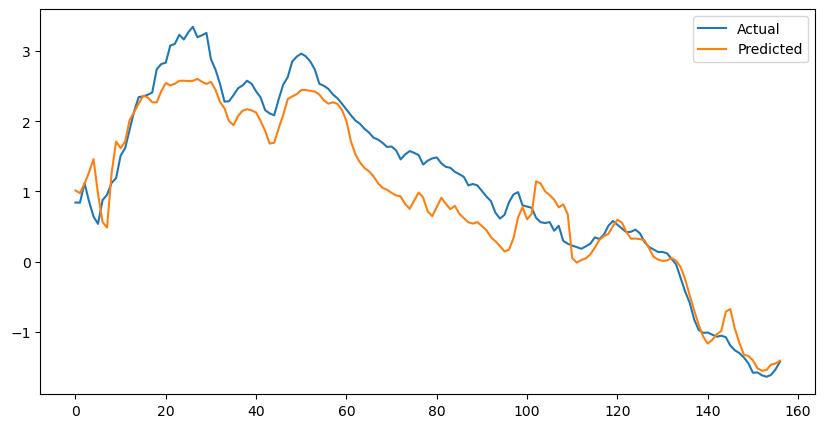

In [19]:
average_model.eval()
with torch.no_grad():
    y_pred_test = average_model(test_tensor_seq4)

# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4.numpy(), label="Actual")
plt.plot(y_pred_test.numpy(), label="Predicted")
plt.legend()
plt.savefig('model123_avg_fl')

In [20]:
mae = criterion3(y_pred_test, test_tensor_labels4)
print(f'Mean Absolute Error: {mae.item()}')
print(f'MARE: {MARE(y_pred_test, test_tensor_labels4)}')

Mean Absolute Error: 0.15996868908405304
MARE: 0.32407647371292114


In [21]:
window = test_tensor_seq4.clone()[0]
average_model(window.unsqueeze(0))

tensor([[1.0140]], grad_fn=<AddmmBackward0>)

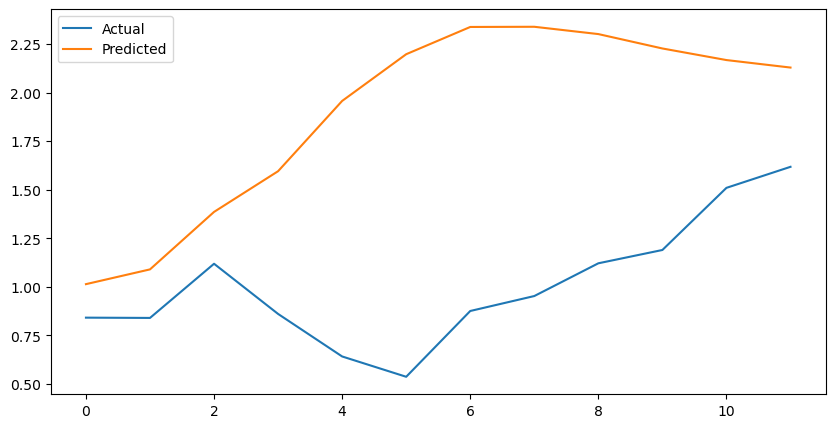

In [26]:
# Sequence prediction
average_model.eval()
N_steps = 12
window = test_tensor_seq4.clone()[0]
predictions = []
with torch.no_grad():
    for _ in range(N_steps):
        next_step_pred = average_model(window.unsqueeze(0))
        # shift window by one
        window = window[1:, :]
        # append prediction
        window = torch.cat((window, next_step_pred))
        # print(next_step_pred.shape)
        predictions.append(next_step_pred.squeeze(0))
    
# Plot test predictions
plt.figure(figsize=(10, 5))
plt.plot(test_tensor_labels4.numpy()[:N_steps], label="Actual")
plt.plot(predictions, label="Predicted")
plt.legend()
plt.savefig('small_seq_model123_avg_fl')        
